# Sentimental Analysis for Hotel Reviews

### 1. Reading datasets

### 1.1. Importing libraries

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
import spacy
import string

from sklearn.feature_extraction.text import TfidfVectorizer

random_state_val = 0

### 1.2. Reading datasets

In [2]:
df_ori = pd.read_json("random_30000_hotel_reviews.JSON", lines=True)

In [3]:
df_ori.head()

,ratings,title,text,author,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile
0,"{'service': 1.0, 'cleanliness': 2.0, 'overall'...",“Horrible experience”,First of all we got there and they didn't have...,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,140716137,False
1,"{'cleanliness': 1.0, 'sleep_quality': 1.0, 'ov...",“Stay Away”,Found Racist graffiti in the room. Request to ...,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,114807323,False
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great location and service”,Close to Union Square - hotel is a bit of a ma...,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,84805430,False
3,"{'service': 3.0, 'cleanliness': 2.0, 'overall'...",“I will never go back here again!”,I had a bad vibe about this place from the mom...,"{'username': 'JoanellenJ', 'num_cities': 10, '...",June 2012,111418,1,2012-06-28,132971117,False
4,{'overall': 1.0},“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...","{'username': 'Lynnworks', 'num_cities': 3, 'nu...",January 2012,671150,3,2012-02-04,124104157,False


The values for 'ratings' and 'author' are stored in dictionary format, so both of them need to be refined.

### 1.3. Tidying the dictionary format of "ratings"

In [4]:
df_rating = pd.DataFrame()
for idx in df_ori["ratings"].index:
    df_rating=pd.concat([df_rating,pd.DataFrame([df_ori["ratings"].iloc[idx]],index=[idx])])
    
df_rating.columns=["rating_"+i for i in df_rating.columns]
print(df_rating.shape)
df_rating.head()

(30000, 9)


,rating_service,rating_cleanliness,rating_overall,rating_value,rating_location,rating_sleep_quality,rating_rooms,rating_check_in_front_desk,rating_business_service_(e_g_internet_access)
0,1.0,2.0,1.0,1.0,3.0,2.0,1.0,NaN,NaN
1,1.0,1.0,1.0,2.0,NaN,1.0,NaN,NaN,NaN
2,4.0,5.0,4.0,3.0,5.0,4.0,4.0,NaN,NaN
3,3.0,2.0,2.0,1.0,4.0,1.0,1.0,NaN,NaN
4,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


### 1.4. Tidying the dictionary format of "author"

In [5]:
df_author = pd.DataFrame()
for idx in df_ori["author"].index:
    df_author=pd.concat([df_author,pd.DataFrame([df_ori["author"].iloc[idx]],index=[idx])])

df_author.columns=["author_"+i for i in df_author.columns]    
print(df_author.shape)
df_author.head()

(30000, 7)


,author_username,author_num_reviews,author_id,author_location,author_num_cities,author_num_helpful_votes,author_num_type_reviews
0,Kh3RD,1.0,AB404BB664D653ECF79DE0E0867F6D34,"Las Vegas, Nevada",NaN,NaN,NaN
1,TheUglyPhotographer,4.0,BB116F87FE8F9AB356F63853BFD32FFE,"Oceanside, California",3.0,4.0,4.0
2,Moonstonemoclips,48.0,F3D0CF371B788300E73A1413B2DABB4B,Kirkland,31.0,27.0,32.0
3,JoanellenJ,22.0,BC6BC07F81B768F78B6CE17A18762C11,New York,10.0,9.0,5.0
4,Lynnworks,3.0,F7E9D044FA2554FD06A871289312E043,Providence,3.0,7.0,3.0


### 1.5.Merging the original datatset with the dataset of "author" and "ratings"

In [6]:
df_all = pd.merge(df_author,df_ori.drop(columns=["ratings","author"]), left_index=True, right_index=True)
df_all = pd.merge(df_all,df_rating,left_index=True, right_index=True)
print(df_all.shape)
df_all.head()

(30000, 24)


,author_username,author_num_reviews,author_id,author_location,author_num_cities,author_num_helpful_votes,author_num_type_reviews,title,text,date_stayed,...,via_mobile,rating_service,rating_cleanliness,rating_overall,rating_value,rating_location,rating_sleep_quality,rating_rooms,rating_check_in_front_desk,rating_business_service_(e_g_internet_access)
0,Kh3RD,1.0,AB404BB664D653ECF79DE0E0867F6D34,"Las Vegas, Nevada",NaN,NaN,NaN,“Horrible experience”,First of all we got there and they didn't have...,September 2012,...,False,1.0,2.0,1.0,1.0,3.0,2.0,1.0,NaN,NaN
1,TheUglyPhotographer,4.0,BB116F87FE8F9AB356F63853BFD32FFE,"Oceanside, California",3.0,4.0,4.0,“Stay Away”,Found Racist graffiti in the room. Request to ...,June 2011,...,False,1.0,1.0,1.0,2.0,NaN,1.0,NaN,NaN,NaN
2,Moonstonemoclips,48.0,F3D0CF371B788300E73A1413B2DABB4B,Kirkland,31.0,27.0,32.0,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,October 2010,...,False,4.0,5.0,4.0,3.0,5.0,4.0,4.0,NaN,NaN
3,JoanellenJ,22.0,BC6BC07F81B768F78B6CE17A18762C11,New York,10.0,9.0,5.0,“I will never go back here again!”,I had a bad vibe about this place from the mom...,June 2012,...,False,3.0,2.0,2.0,1.0,4.0,1.0,1.0,NaN,NaN
4,Lynnworks,3.0,F7E9D044FA2554FD06A871289312E043,Providence,3.0,7.0,3.0,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...",January 2012,...,False,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


### 2. Exploratory Data Analysis (EDA)

### 2.1 Analyse the distribution of the "rating_overall"

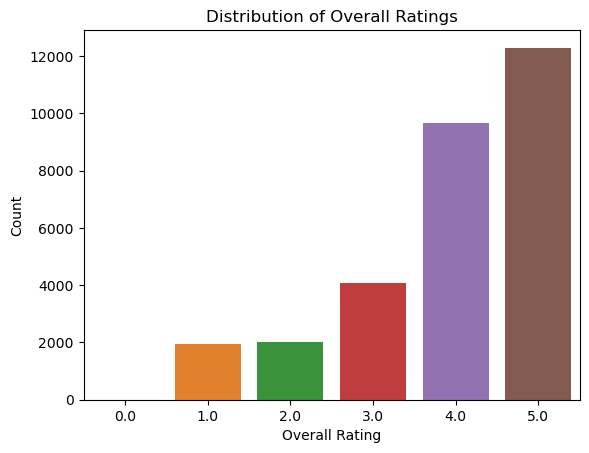

In [7]:
sns.countplot(x='rating_overall', data=df_all)
plt.title('Distribution of Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Count')
plt.show()


The ratings 4 and 5 dominate the majority. When dividing the ratings into positive and negative sentiment based on the number of data points, it seems appropriate to consider 4 and 5 as "positive", and 1, 2, 3 as "negative". In that case, it might be unnecessary to use data balancing techniques such as downsampling and upsampling because the disparity between the counts of positive and negative instances is not large such as being more than tenfold.

### 2.2 Analyse the length of the title and the text

text_len     120.0
title_len      4.0
dtype: float64

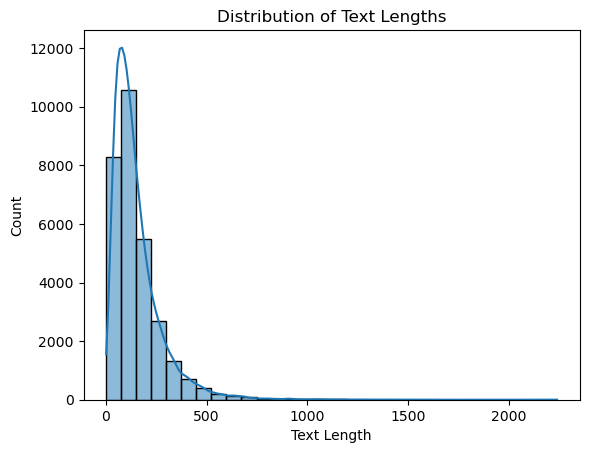

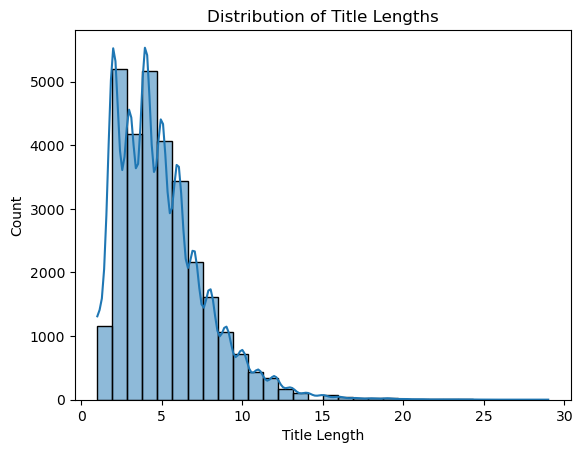

In [8]:
df_all['text_len'] = df_all['text'].apply(lambda x: len(x.split()))
df_all['title_len'] = df_all['title'].apply(lambda x: len(x.split()))
display(df_all[["text_len","title_len"]].median())

# Show the histgram of text lengths
sns.histplot(df_all['text_len'], bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.show()
print()

# Show the histgram of title lengths
sns.histplot(df_all['title_len'], bins=30, kde=True)
plt.title('Distribution of Title Lengths')
plt.xlabel('Title Length')
plt.show()

The above plots examine the word count tendencies for the title and text, which will be used as features in this analysis. It was observed that titles are compactly written within 10 words, while the text contains a substantial amount of information.

This assignment requires the selection of the optimal model from the following list:

- Multinomial Naïve Bayes (MNB)
- Random Forest (RF)
- Linear Regression
- SVM
- k-NN
- Multilayer Perceptron (MLP)

Due to the large amount of text used for training, SVM, which requires more time for learning, will be excluded from consideration. Additionally, Linear Regression, which does not achieve the same level of accuracy as MLP among linear regression models, will also be excluded. Furthermore, k-NN, not expected to perform as well as Random Forest in terms of accuracy, will be omitted from consideration. Therefore, the optimal model will be considered from MNB, RF, and MLP.

,text_len,title_len
rating_overall,,
0.0,29.0,10.0
1.0,151.0,4.0
2.0,162.0,5.0
3.0,140.0,5.0
4.0,118.0,4.0
5.0,106.0,4.0


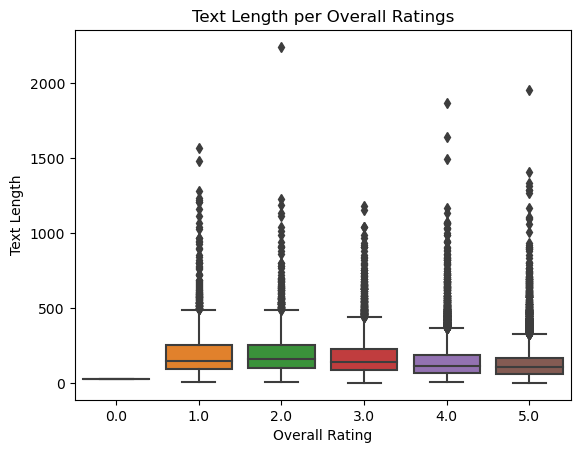

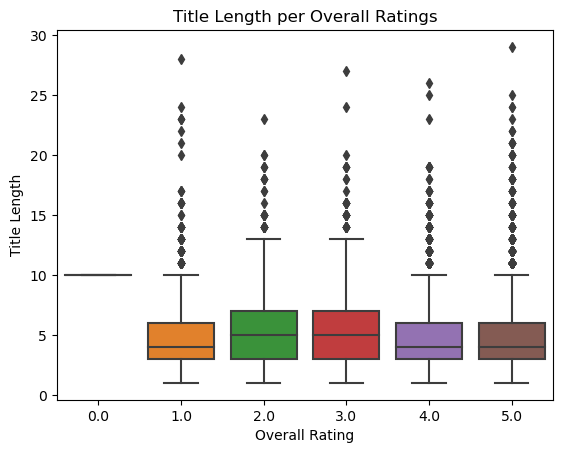

In [9]:
display(df_all.groupby("rating_overall")[["text_len","title_len"]].median())

# Analyse the distribution of text lengths per rating
sns.boxplot(x="rating_overall", y="text_len", data=df_all)
plt.title('Text Length per Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Text Length')
plt.show()

# Analyse the distribution of text lengths per rating
sns.boxplot(x="rating_overall", y="title_len", data=df_all)
plt.title('Title Length per Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Title Length')
plt.show()


When analysing the word count for each rating, there is not a significant change observed in the title; however, in the text, ratings 1 to 3 have longer word counts compared to ratings 4 and 5. This indicates that the text tends to be longer if the customer is not satisfied.

### 2.3. Analysing the frequently occurring words for each rating

It is speculated that customer sentiments are likely to be expressed through adjectives in both the title and text. In the following graphs, I analyse frequently occurring adjective words.

In [10]:
nlp = spacy.load("en_core_web_sm")

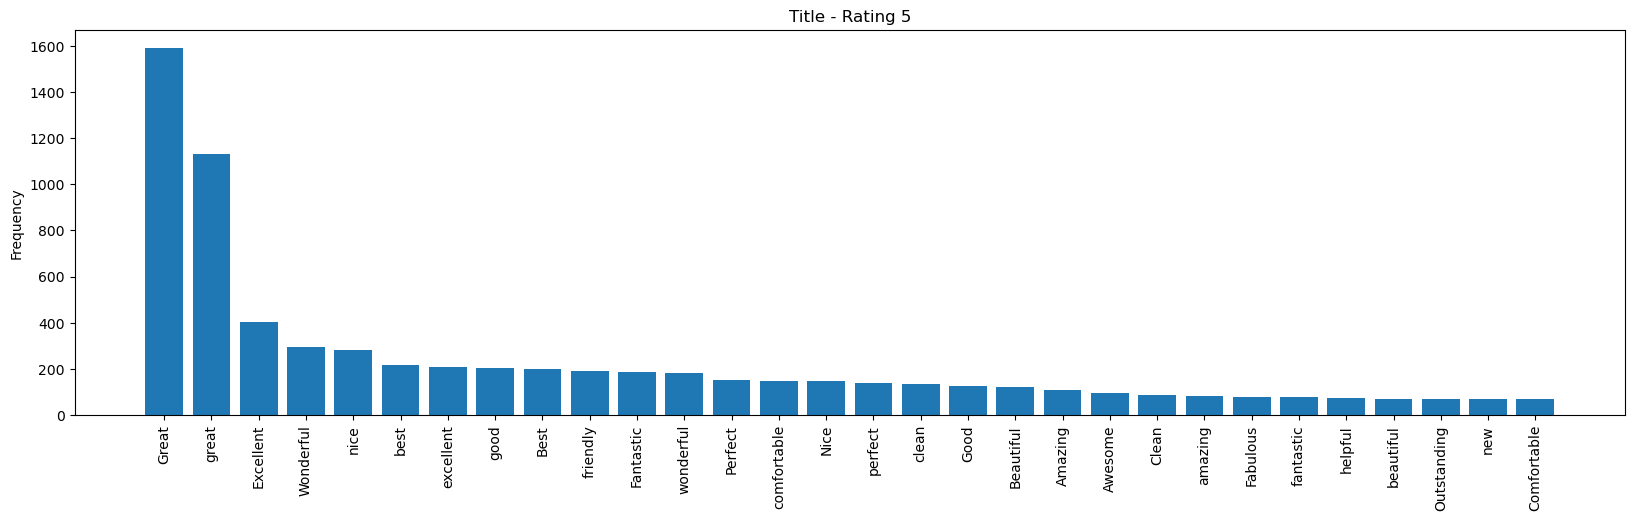

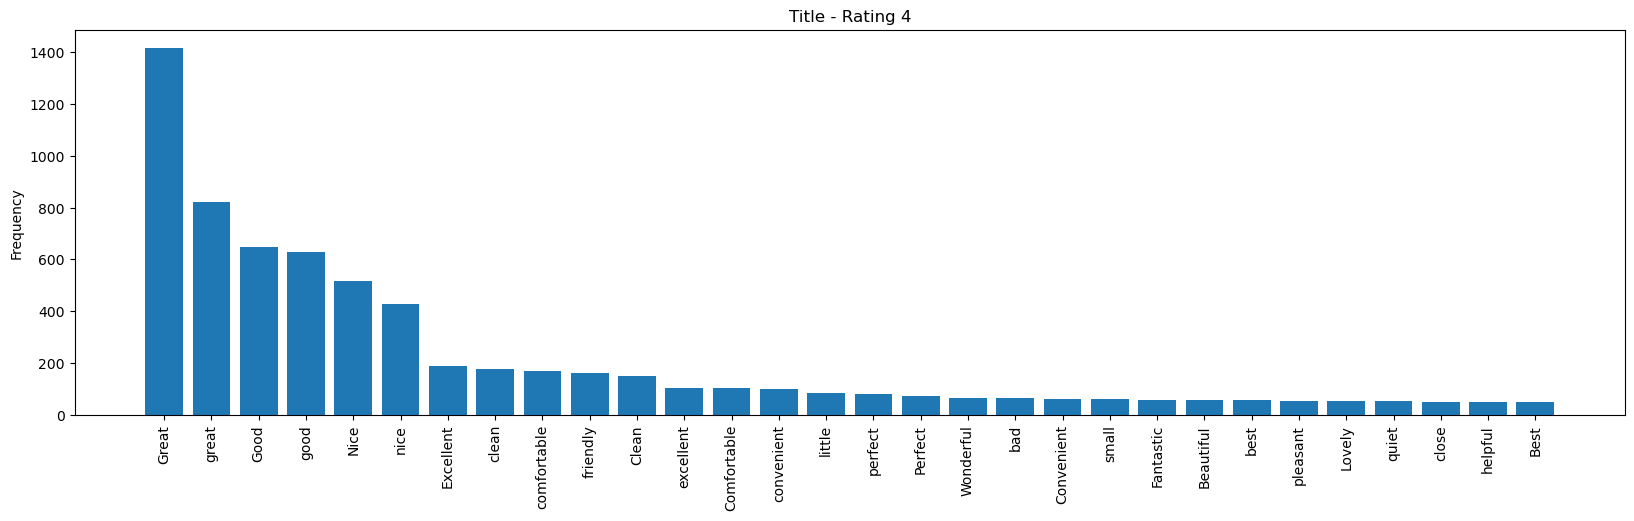

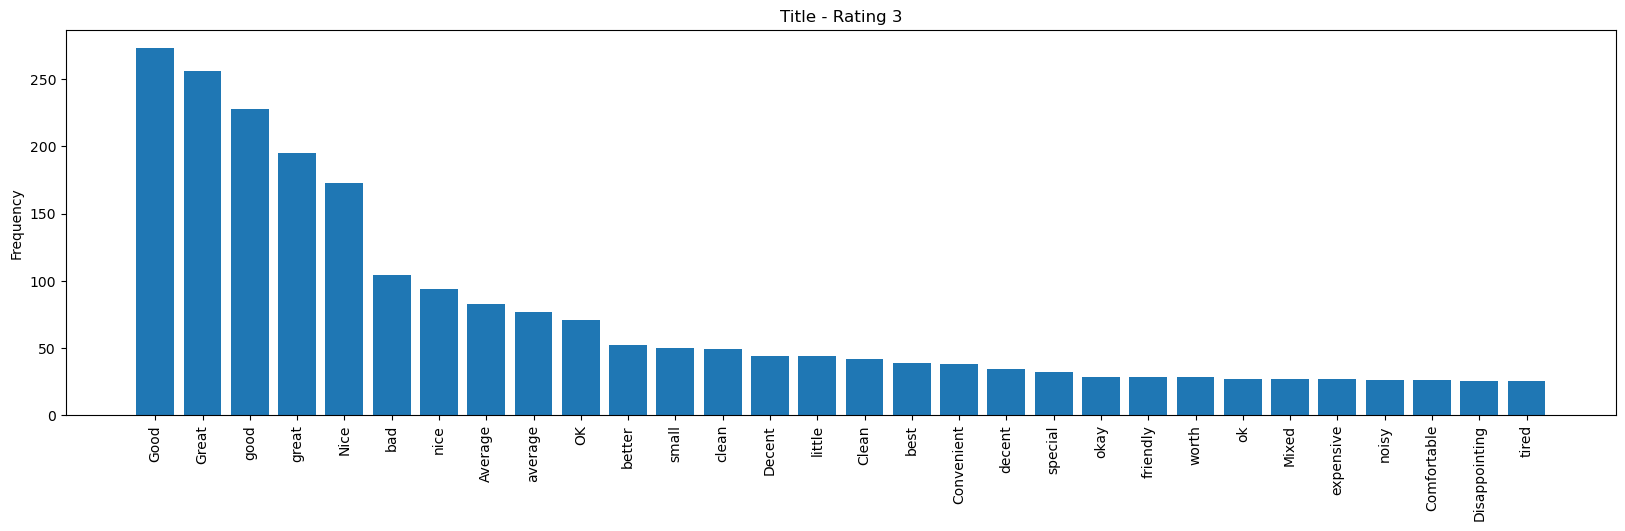

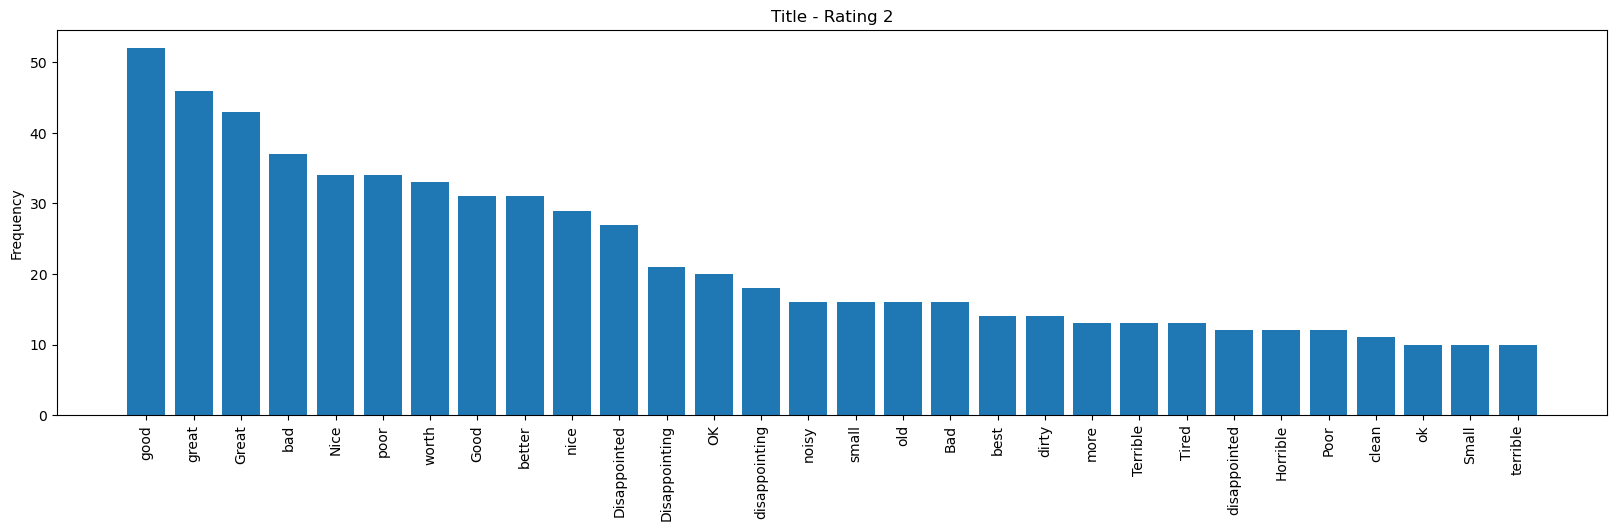

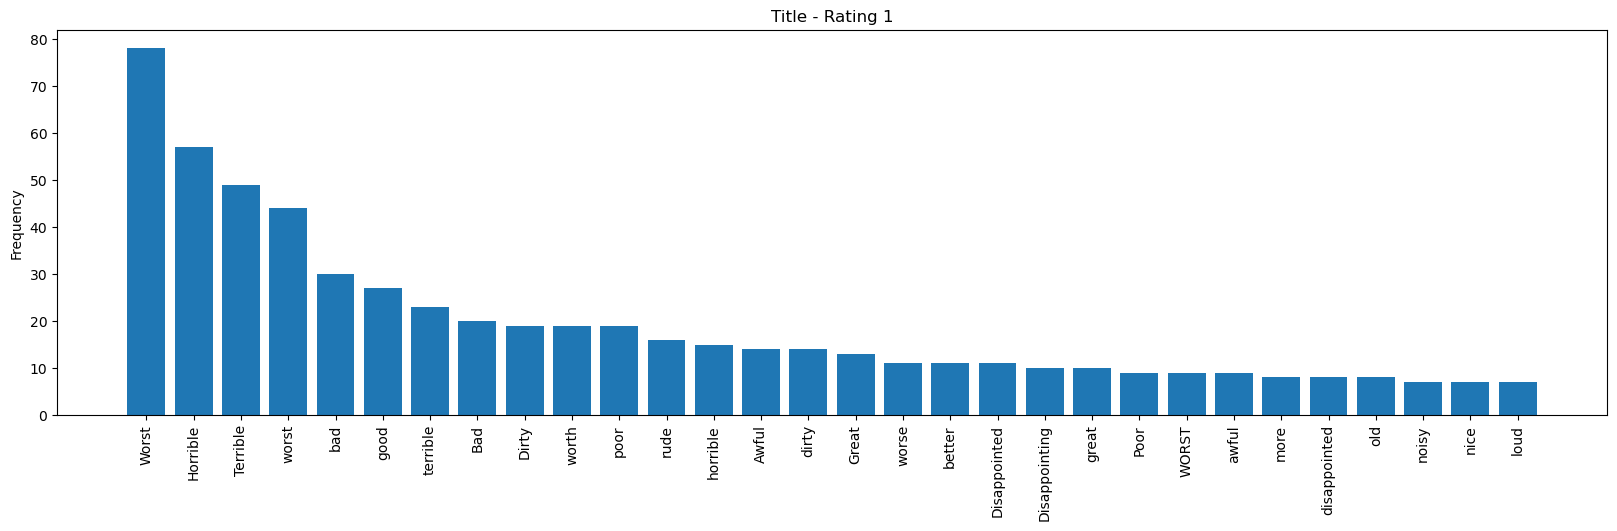

In [11]:
# Analysing the frequently occurring words in the titles
for i in range(5,0,-1):
    dic_adj_adv={}
    for text in df_all[df_all["rating_overall"]==i]["title"]:
        doc = nlp(text)

        for token in doc:
            if token.pos_ == "ADJ":
                if token.text in dic_adj_adv.keys():
                    dic_adj_adv[token.text] += 1
                else:
                    dic_adj_adv[token.text] = 1

    plt.figure(figsize=(20,5))
    df_count = pd.DataFrame({"key":dic_adj_adv.keys(),"val":dic_adj_adv.values()})
    df_count.sort_values("val", ascending=False, inplace=True)
    plt.bar(df_count.iloc[0:30,:]["key"], df_count.iloc[0:30,:]["val"])
    plt.title(f"Title - Rating {i}")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.show()

It is noteworthy that the term 'bad' appears within the top 10 frequent words for ratings 1 to 3, which indicate a negative sentiment, though it cannot be generalised due to the possibility of negative forms of sentences.

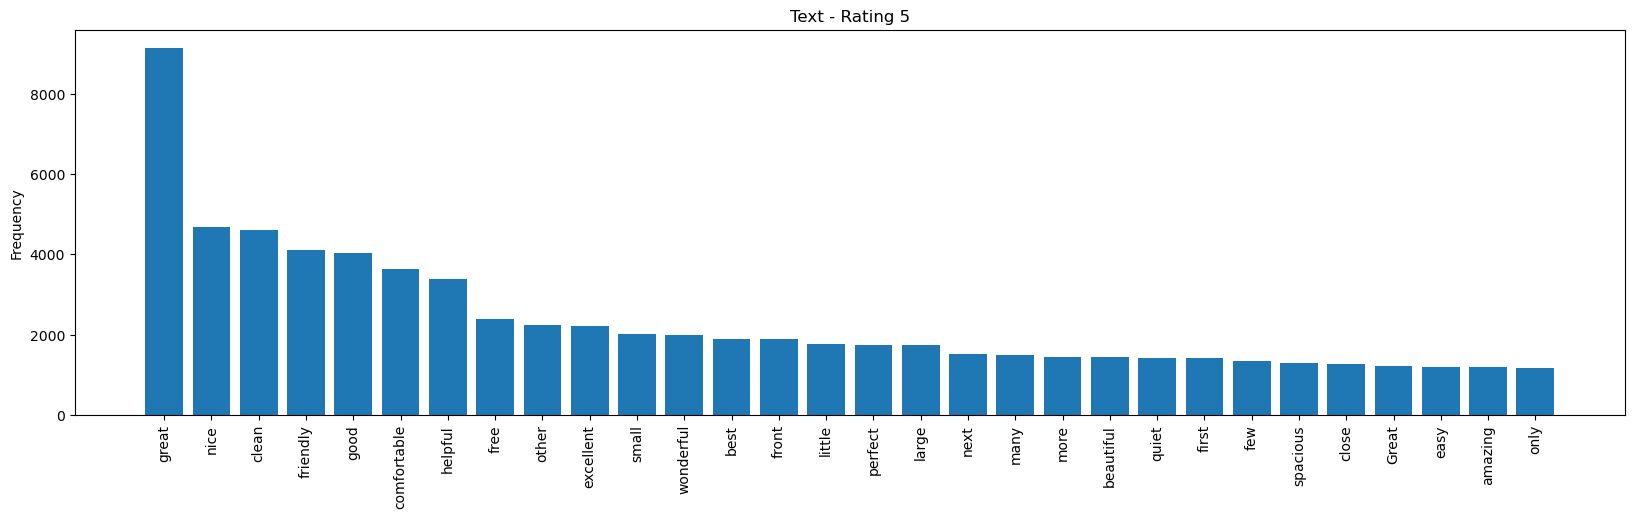

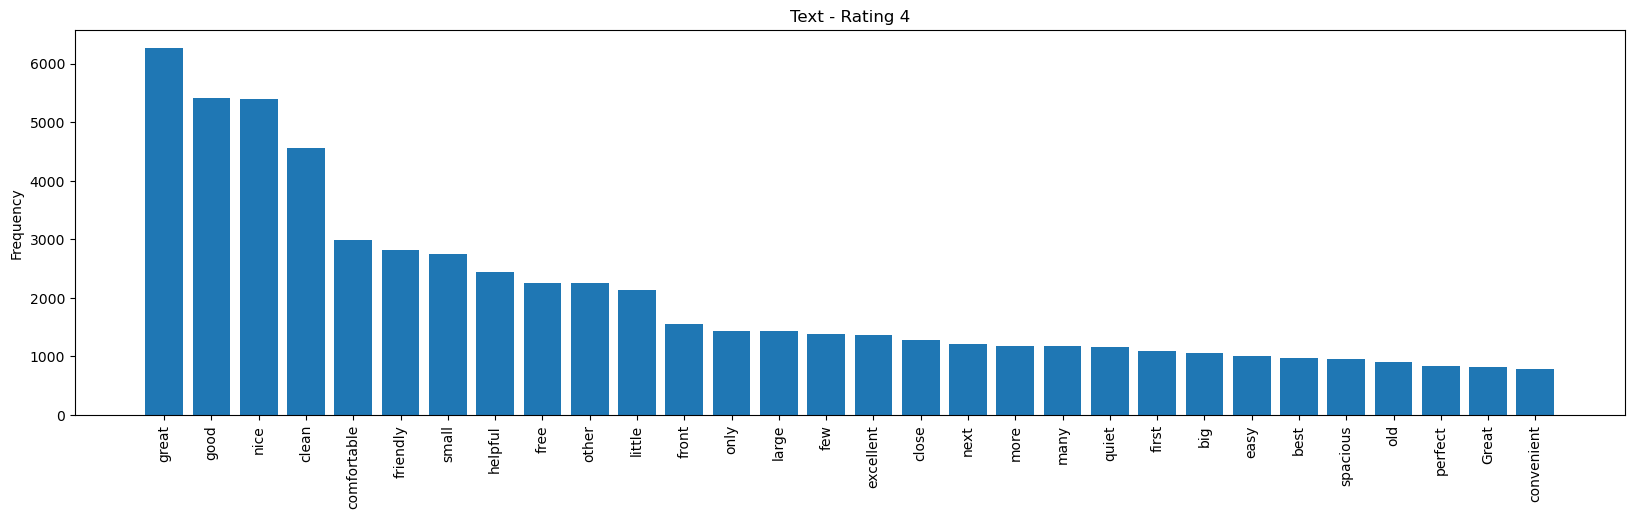

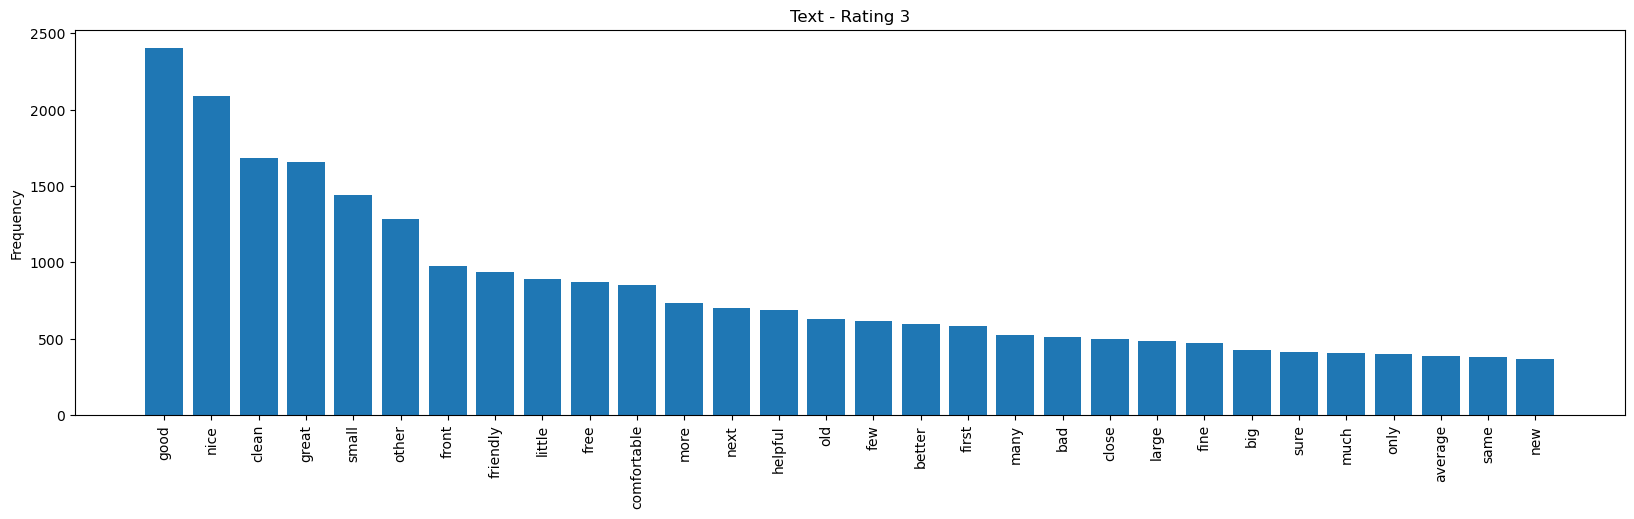

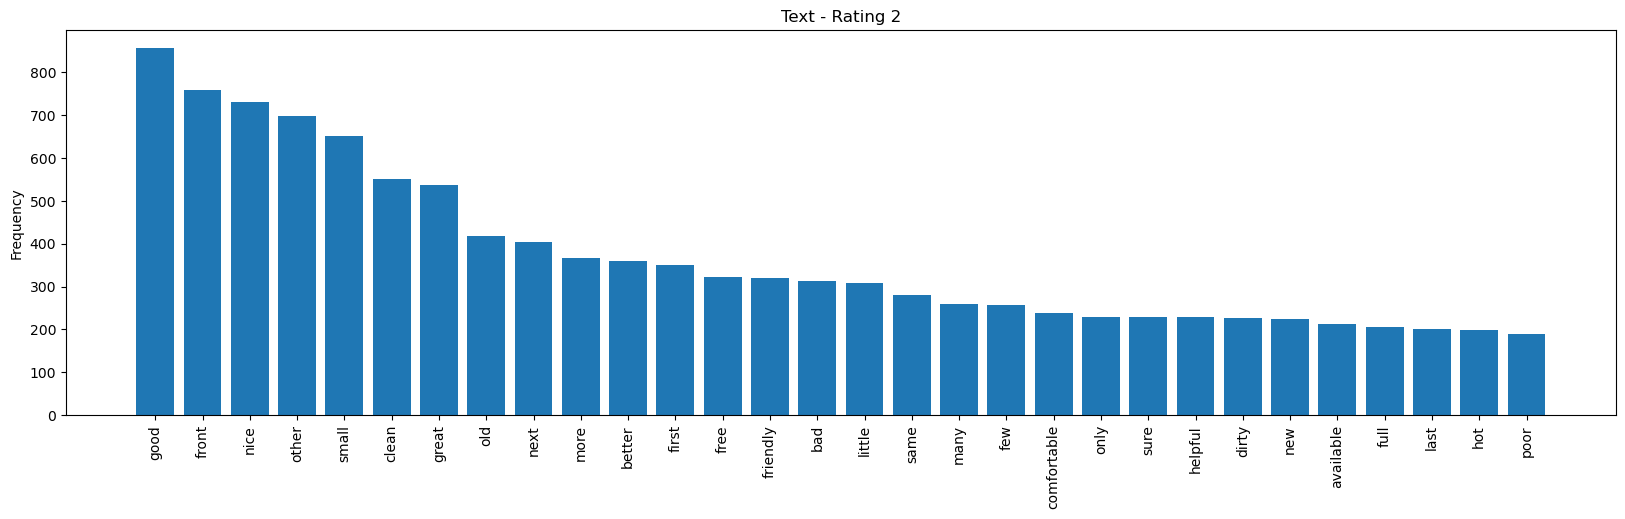

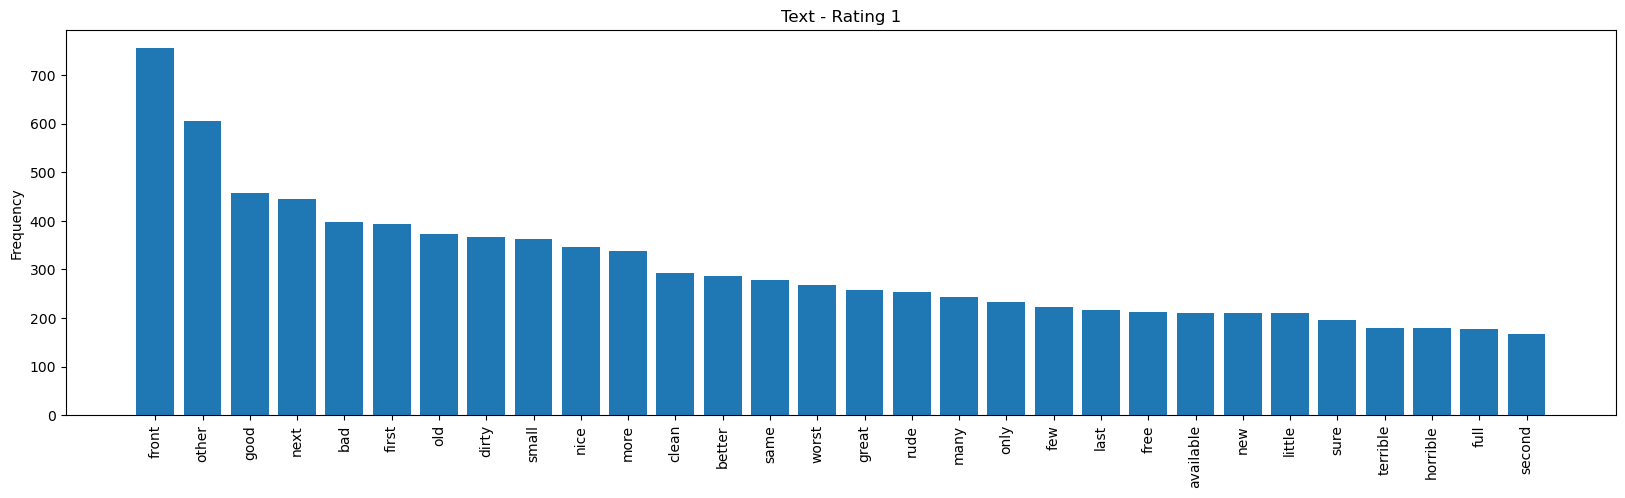

In [12]:
# Analysing the frequently occurring words in the texts
for i in range(5,0,-1):
    dic_adj_adv={}
    for text in df_all[df_all["rating_overall"]==i]["text"]:
        doc = nlp(text)

        for token in doc:
            if token.pos_ == "ADJ":
                if token.text in dic_adj_adv.keys():
                    dic_adj_adv[token.text] += 1
                else:
                    dic_adj_adv[token.text] = 1

    plt.figure(figsize=(20,5))
    df_count = pd.DataFrame({"key":dic_adj_adv.keys(),"val":dic_adj_adv.values()})
    df_count.sort_values("val", ascending=False, inplace=True)
    plt.bar(df_count.iloc[0:30,:]["key"], df_count.iloc[0:30,:]["val"])
    plt.title(f"Text - Rating {i}")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.show()

It is evident that the term 'bad' appears for ratings 1 to 3, which indicate a negative sentiment, though it cannot be generalised due to the possibility of negative forms of sentences.

In summary, both titles and texts exhibit negative sentiments in ratings 1 to 3. While specific titles and texts are omitted for brevity, the following tendencies were observed in the samples:

- Rating 4 or 5: Positive content
- Rating 3: Few positive expressions, and negative expressions begin to appear
- Rating 1: Negative content

In [13]:
# Run the following command if the sample check is necessary
rating_val = 1
print("-----samples of titles-----")
print(df_all[df_all["rating_overall"]==rating_val].head(3)["title"].values)
print("-----samples of texts-----")
print(df_all[df_all["rating_overall"]==rating_val].head(3)["text"].values)
print("--------------------------")

-----samples of titles-----
['“Horrible experience”' '“Stay Away”'
 '“Ripped off our VISA card after departure”']
-----samples of texts-----
['First of all we got there and they didn\'t have the room we booked; did not pay us the difference from the room we booked to the cheaper one they gave us. STAFF took forever to address our problem, not KID friendly, pool dirty- and parking wow good luck going somewhere at night time and come back to the hotel to try to find a parking space THAT THEY CHARGE AN ADDITIONAL FEE FOR! (NOT INCLUDED IN THEIR OVERPRICED HOTEL STAY)\nWe thought by paying more we would get a good deal well this hotel is not the case!!\n$400 for a 2 night stay plus horrible customer service and a manager who never returned our call when we submitted the complain is not how you do business- They are giving SHERATON a horrible reputation- I guess they are managed by SHERATON but have their own "policies" and undesirable customer service.\nGreat time in San Diego but a nightm

Based on the "2.3", when classifying from ratings into binary categories of "positive" and "negative" It is desirable to classify Ratings 1 to 3 as "negative" since they tend to have negative expressions and to classify Ratings 4 and 5 as "positive", given their abundance of positive expressions.
Additionally, considering the data counts for each rating in "2.1" and the trends in text quantity for each rating in "2.2," it can be said that the aforementioned classification method is preferable."

### 2.4. Checking the missing values

In [14]:
print("The number of the text null",len(df_all[df_all['text'].isnull()]))
print("The number of the title null",len(df_all[df_all['title'].isnull()]))

The number of the text null 0
The number of the title null 0


There is no missing values in the texts and titles.

In [15]:
print("The number of the rating null",len(df_all[df_all['rating_overall'].isnull()]))
df_all["rating_overall"].value_counts()

The number of the rating null 0


rating_overall
5.0    12293
4.0     9653
3.0     4080
2.0     2031
1.0     1942
0.0        1
Name: count, dtype: int64

There are no missing values in the rating_overall. However, it is necessary to check rating_overall 0, which has a data count of 1, due to the possibility of input error.

### 2.5. Checking the data point where the 'rating_overall' is 0

In [16]:
print(df_all[df_all["rating_overall"]==0]["title"].values[0])
print(df_all[df_all["rating_overall"]==0]["text"].values[0])

“Perfect Location, large room - stayed for two weeks :)”
Best location. Right where Pier 39 is. Lots of things to do around the area, restaurants and sight seeing. Staff are friendly. Great service. Will come back again :)


Both the title and text contain no negative expressions, consisting only of positive content; therefore, the rating_overall is equivalent to 5.

### 2.6. Checking the existence of URL

In [17]:
print("The number of http in text",len(df_all[df_all["title"].str.contains("http")]))
print("The number of http in text",len(df_all[df_all["text"].str.contains("http")]))

The number of http in text 1
The number of http in text 22


URLs are strings unrelated to emotions, so they should be removed.

### 2.7. Checking the existence of non-ASCII

In [18]:
print("The number of non-ASCII in title",len(df_all[df_all['title'].apply(lambda x: any(ord(char) > 127 for char in x))]))
print("The number of non-ASCII in text",len(df_all[df_all['text'].apply(lambda x: any(ord(char) > 127 for char in x))]))


The number of non-ASCII in title 30000
The number of non-ASCII in text 964


Non-ASCII characters will also be removed to enhance data quality.

### 2.8. Summarising the findings for the subsequent process

- Building the MNB, RF, and MLP model and Choosing the optimal model from them (according to 2.2)
- Classifying Ratings 1 to 3 as "negative" ,plus Ratings 4 and 5 as "positive" (according to 2.1, 2.2 and 2.3)
- Fixing 'rating_overall' from 0 to 5 (according to 2.5)
- Remove the URL and non-ASCII (according to 2.6 and 2.7)
- Not using data balancing techniques (according to 2.2)

I omit the analysis of other obvious elements such as punctuation and newline characters. However, it is necessary to exclude punctuation and newline characters to judge based on emotional expressions

### 3. Preprocessing

### 3.1. Fixing "rating_overall"

In [20]:
df_all["rating_overall"] = np.where(df_all["rating_overall"]==0,5,df_all["rating_overall"])

### 3.2. Creating the target variable

In [21]:
df_all["y"] = np.where(df_all["rating_overall"]>=4,1,0)

In [22]:
df_all["y"].value_counts()

y
1    21947
0     8053
Name: count, dtype: int64

### 3.3. Concatenating the "title" and the "text"

In [23]:
df_all["title_text"] = df_all["title"] + " " + df_all["text"]

### 3.4. Cleaning the dataset

In [24]:
cnt_clean_text=0
def clean_text(text):
    global cnt_clean_text
    if cnt_clean_text % 100 == 0:
        print("count",cnt_clean_text)
    cnt_clean_text+=1
    # Remove urls
    text = re.sub(r"http\S+", "", text)
    
    # Remove non-ASCII characters
    text = ''.join([char for char in text if ord(char) < 128])
    
    # Remove punctuation
    text = text.translate(text.maketrans('', '', string.punctuation))
    
    # Tokenise the text to tidy words and remove newline characters
    tokens = word_tokenize(text)
    
    return " ".join(tokens)


In [25]:
cnt_remove_stopwords=0
def remove_stopwords(text):
    global cnt_remove_stopwords
    if cnt_remove_stopwords % 100 == 0:
        print("count",cnt_remove_stopwords)
    cnt_remove_stopwords+=1

    # Tokenise the text
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    
    return " ".join(tokens)

In [26]:
cnt_lemmatise_text=0
def lemmatise_text(text):
    global cnt_lemmatise_text
    if cnt_lemmatise_text % 100 == 0:
        print("count",cnt_lemmatise_text)
    cnt_lemmatise_text+=1

    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    
    return " ".join(tokens)


In [27]:
df_all["clean_text"] =  df_all["title_text"].apply(lambda x: clean_text(x))

count 0
count 100
count 200
count 300
count 400
count 500
count 600
count 700
count 800
count 900
count 1000
count 1100
count 1200
count 1300
count 1400
count 1500
count 1600
count 1700
count 1800
count 1900
count 2000
count 2100
count 2200
count 2300
count 2400
count 2500
count 2600
count 2700
count 2800
count 2900
count 3000
count 3100
count 3200
count 3300
count 3400
count 3500
count 3600
count 3700
count 3800
count 3900
count 4000
count 4100
count 4200
count 4300
count 4400
count 4500
count 4600
count 4700
count 4800
count 4900
count 5000
count 5100
count 5200
count 5300
count 5400
count 5500
count 5600
count 5700
count 5800
count 5900
count 6000
count 6100
count 6200
count 6300
count 6400
count 6500
count 6600
count 6700
count 6800
count 6900
count 7000
count 7100
count 7200
count 7300
count 7400
count 7500
count 7600
count 7700
count 7800
count 7900
count 8000
count 8100
count 8200
count 8300
count 8400
count 8500
count 8600
count 8700
count 8800
count 8900
count 9000
count 9100


In [28]:
df_prep = df_all.copy()[["y","clean_text","rating_overall"]]

In [29]:
df_prep["lower_text"] = df_prep["clean_text"].apply(lambda x: x.lower())

In [30]:
df_prep["non_stopwords"] = df_prep["clean_text"].apply(lambda x: remove_stopwords(x))

count 0
count 100
count 200
count 300
count 400
count 500
count 600
count 700
count 800
count 900
count 1000
count 1100
count 1200
count 1300
count 1400
count 1500
count 1600
count 1700
count 1800
count 1900
count 2000
count 2100
count 2200
count 2300
count 2400
count 2500
count 2600
count 2700
count 2800
count 2900
count 3000
count 3100
count 3200
count 3300
count 3400
count 3500
count 3600
count 3700
count 3800
count 3900
count 4000
count 4100
count 4200
count 4300
count 4400
count 4500
count 4600
count 4700
count 4800
count 4900
count 5000
count 5100
count 5200
count 5300
count 5400
count 5500
count 5600
count 5700
count 5800
count 5900
count 6000
count 6100
count 6200
count 6300
count 6400
count 6500
count 6600
count 6700
count 6800
count 6900
count 7000
count 7100
count 7200
count 7300
count 7400
count 7500
count 7600
count 7700
count 7800
count 7900
count 8000
count 8100
count 8200
count 8300
count 8400
count 8500
count 8600
count 8700
count 8800
count 8900
count 9000
count 9100


In [31]:
df_prep["lemmatise_text"] = df_prep["clean_text"].apply(lambda x: lemmatise_text(x))

count 0
count 100
count 200
count 300
count 400
count 500
count 600
count 700
count 800
count 900
count 1000
count 1100
count 1200
count 1300
count 1400
count 1500
count 1600
count 1700
count 1800
count 1900
count 2000
count 2100
count 2200
count 2300
count 2400
count 2500
count 2600
count 2700
count 2800
count 2900
count 3000
count 3100
count 3200
count 3300
count 3400
count 3500
count 3600
count 3700
count 3800
count 3900
count 4000
count 4100
count 4200
count 4300
count 4400
count 4500
count 4600
count 4700
count 4800
count 4900
count 5000
count 5100
count 5200
count 5300
count 5400
count 5500
count 5600
count 5700
count 5800
count 5900
count 6000
count 6100
count 6200
count 6300
count 6400
count 6500
count 6600
count 6700
count 6800
count 6900
count 7000
count 7100
count 7200
count 7300
count 7400
count 7500
count 7600
count 7700
count 7800
count 7900
count 8000
count 8100
count 8200
count 8300
count 8400
count 8500
count 8600
count 8700
count 8800
count 8900
count 9000
count 9100


In [32]:
df_prep.head()

,y,clean_text,rating_overall,lower_text,non_stopwords,lemmatise_text
0,0,Horrible experience First of all we got there ...,1.0,horrible experience first of all we got there ...,Horrible experience First got didnt room booke...,horrible experience first of all we get there ...
1,0,Stay Away Found Racist graffiti in the room Re...,1.0,stay away found racist graffiti in the room re...,Stay Away Found Racist graffiti room Request c...,stay away find Racist graffiti in the room req...
2,1,Great location and service Close to Union Squa...,4.0,great location and service close to union squa...,Great location service Close Union Square hote...,great location and service close to Union Squa...
3,0,I will never go back here again I had a bad vi...,2.0,i will never go back here again i had a bad vi...,never go back bad vibe place moment walked mai...,I will never go back here again I have a bad v...
4,0,Ripped off our VISA card after departure After...,1.0,ripped off our visa card after departure after...,Ripped VISA card departure received final bill...,rip off our VISA card after departure after we...


### 3.5. Creating X and y

The feature is vectorised using TF-IDF, and X_trains are created bellow.  
y for training, development, and test can be created here. On the other hand, X for training can be made here, but X for development and test can be created after determining the optimal preprocessing among stop-word removal, lemmatization, and lowercasing 

In [33]:
vectorizer_clean = TfidfVectorizer()
vectorizer_lower = TfidfVectorizer()
vectorizer_stopwords = TfidfVectorizer()
vectorizer_lemmatise = TfidfVectorizer()

X_train_clean = vectorizer_clean.fit_transform(df_prep['clean_text'][:10000])
X_train_lower = vectorizer_lower.fit_transform(df_prep['lower_text'][:10000])
X_train_stopwords = vectorizer_stopwords.fit_transform(df_prep['non_stopwords'][:10000])
X_train_lemmatise = vectorizer_clean.fit_transform(df_prep['lemmatise_text'][:10000])

y_train = df_prep["y"][:10000]
y_dev = df_prep["y"][10000:20000]
y_test = df_prep["y"][20000:]

### 4. Selecting supervised method for sentiment classification

### 4.1. Importing libraries to build and testing the model

In [34]:
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

### 4.2. Selecting the optimal model

- Evaluation metric:  
Accuracy, which representing the correctness rate, is used for the evaluation metric. Besides ROC-AUC, which indicates ordinal performance, is selected as a precaution. However, the only Accuracy will be used in future assessments if the performance can be adequately measured using Accuracy alone.  
  
- Validation:  
Similar to selecting text processing, which is subsequent process, the predictive accuracy of the models will be measured through cross-validation to ensure a robust evaluation.

In [35]:
print("Random Forest (RF)")
rf_model = RandomForestClassifier(random_state = random_state_val)
scores_rf_acc = cross_val_score(rf_model, X_train_clean, y_train, cv=10, scoring="accuracy")
scores_rf_roc = cross_val_score(rf_model, X_train_clean, y_train, cv=10, scoring="roc_auc")

print("Multinomial Naïve Bayes (MNB)")
mnb_model = MultinomialNB()
scores_mnb_acc = cross_val_score(mnb_model, X_train_clean, y_train, cv=10, scoring="accuracy")
scores_mnb_roc = cross_val_score(mnb_model, X_train_clean, y_train, cv=10, scoring="roc_auc")

print("Multilayer Perceptron (MLP)")
mlp_model = MLPClassifier(random_state = random_state_val)
scores_mlp_acc = cross_val_score(mlp_model, X_train_clean, y_train, cv=10, scoring="accuracy")
scores_mlp_roc = cross_val_score(mlp_model, X_train_clean, y_train, cv=10, scoring="roc_auc")


Random Forest (RF)
Multinomial Naïve Bayes (MNB)
Multilayer Perceptron (MLP)


In [36]:
df_model_selection_rf = pd.DataFrame({"acc":scores_rf_acc,"roc":scores_rf_roc})
df_model_selection_rf["model"] = "rf"

df_model_selection_mnb = pd.DataFrame({"acc":scores_mnb_acc,"roc":scores_mnb_roc})
df_model_selection_mnb["model"] = "mnb"

df_model_selection_mlp = pd.DataFrame({"acc":scores_mlp_acc,"roc":scores_mlp_roc})
df_model_selection_mlp["model"] = "mlp"

df_model_selection = pd.concat([df_model_selection_rf,df_model_selection_mnb])
df_model_selection = pd.concat([df_model_selection,df_model_selection_mlp])

In [37]:
df_model_selection.groupby("model")[["acc","roc"]].agg(['mean', 'median'])

acc               roc          
         mean  median      mean    median
model                                    
mlp    0.8830  0.8850  0.932382  0.932186
mnb    0.7426  0.7425  0.893967  0.890515
rf     0.8137  0.8140  0.917166  0.919650

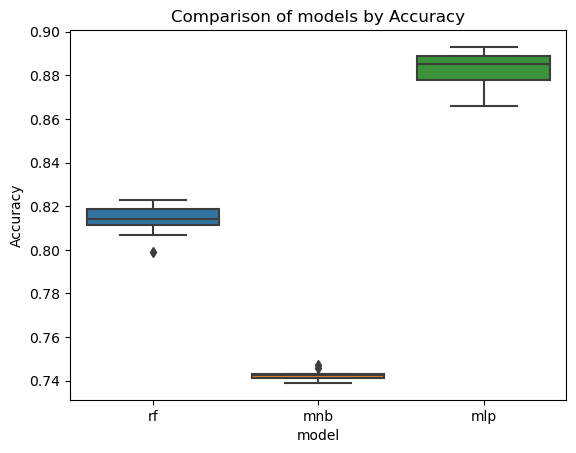

In [38]:
sns.boxplot(x="model", y="acc", data=df_model_selection)
plt.title('Comparison of models by Accuracy')
plt.ylabel('Accuracy')
plt.show()


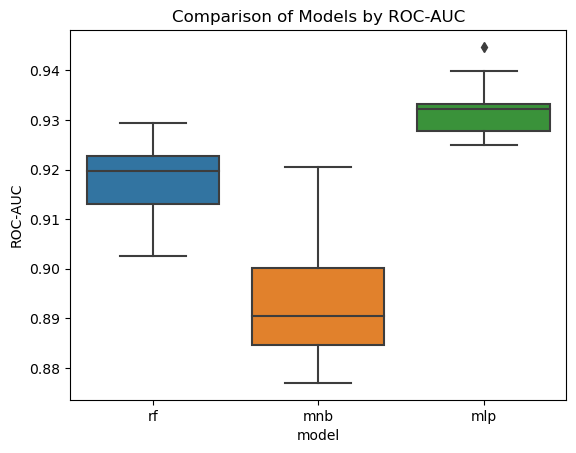

In [39]:
sns.boxplot(x="model", y="roc", data=df_model_selection)
plt.title('Comparison of Models by ROC-AUC')
plt.ylabel('ROC-AUC')
plt.show()


the MLP model is the best since it demonstrates high Accuracy and ROC-AUC.  
Accuracy provides a clearer indication of model differences compared to ROC-AUC. Therefore It might be no problem to use only Accuracy as the evaluation metric from here.

### 4.3. Selecting the optimal text processing

In [40]:
print("stop-word removal")
stopword_model = MLPClassifier(random_state = random_state_val)
scores_stopword_acc = cross_val_score(stopword_model, X_train_stopwords, y_train, cv=10, scoring="accuracy")

print("lemmatisation")
lemma_model = MLPClassifier(random_state = random_state_val)
scores_lemma_acc = cross_val_score(lemma_model, X_train_lemmatise, y_train, cv=10, scoring="accuracy")

print("lowercasing")
lower_model = MLPClassifier(random_state = random_state_val)
scores_lower_acc = cross_val_score(lower_model, X_train_lower, y_train, cv=10, scoring="accuracy")


stop-word removal
lemmatisation
lowercasing


In [41]:
df_processing_stopword = pd.DataFrame({"acc":scores_stopword_acc})
df_processing_stopword["text_processing"] = "stop-word removal"

df_processing_lemma = pd.DataFrame({"acc":scores_lemma_acc})
df_processing_lemma["text_processing"] = "lemmatisation"

df_processing_lower = pd.DataFrame({"acc":scores_lower_acc})
df_processing_lower["text_processing"] = "lowercasing"

df_processing_selection = pd.concat([df_processing_stopword,df_processing_lemma])
df_processing_selection = pd.concat([df_processing_selection,df_processing_lower])

In [42]:
df_processing_selection.groupby("text_processing")["acc"].agg(['mean', 'median'])

,mean,median
text_processing,,
lemmatisation,0.8775,0.8745
lowercasing,0.8830,0.8850
stop-word removal,0.8784,0.8805


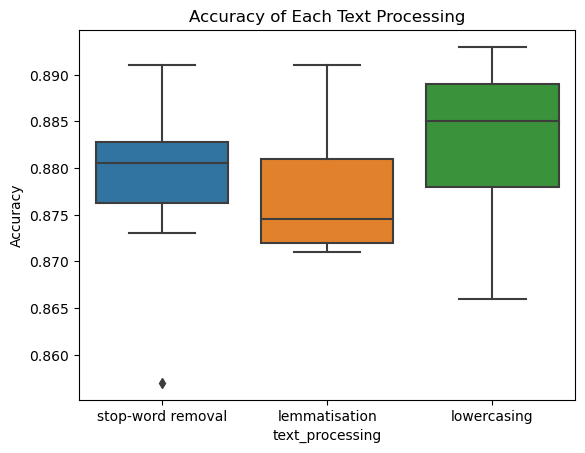

In [43]:
sns.boxplot(x="text_processing", y="acc", data=df_processing_selection)
plt.title('Accuracy of Each Text Processing')
plt.ylabel('Accuracy')
plt.show()


While there is a slight fluctuation in accuracy, the median accuracy of lowercasing is higher than the other two text processing methods. Therefore, lowercasing is preferable to select.

### 4.4. Showing the best result

In [44]:
print("Accuracy:")
display(df_processing_lower["acc"].agg(["mean","median"]))

Accuracy:


mean      0.883
median    0.885
Name: acc, dtype: float64

The above accuracy is obtained when the following choices are made for the evaluation metric, model, and text processing
- Using Accuracy as the evaluation metric (according to 4.2).
- Choosing MLP as the model (according to 4.2).
- Selecting lowercasing as the text processing method (according to 4.3).

### 4.5 Commenting why this preprocessing works best

- <b>Model (MLP):</b>  
MLP is a neural network model that achieves high accuracy due to the combination of non-linearity (activation functions) and linearity, enabling the representation of complex data compared to the other two machine learning model. MLP is considered a suitable model for natural language processing as well as RNN-based models, which are also composed of neural network and have high accuracy.
  
- <b>Text Processing (Lowercasing):</b>  
If lowercasing is not applied, words with uppercase letters and words composed entirely of lowercase characters are treated as different, even if they are the same words. However, In English sentences, as the initial letter of the first word is capitalised, words composed entirely of lowercase letters are treated differently. Using lowercasing allows them to be considered the same, contributing to the accuracy compared to the rest of two pre-processing.

### 5. Sentiment classification using VADER lexicon and method

### 5.1. Using VADER on the dev dataset for sentiment prediction

When 'rating_overall' is 3, it is considered as a negative sentiment; therefore, if the VADER score is neutral, it is regarded as a negative sentiment.

In [46]:
from nltk.sentiment import SentimentIntensityAnalyzer

# # Downloading the resource if necessary
# import nltk
# nltk.download("vader_lexicon")

# Creating the dev dataset
dev_text = df_prep['lower_text'][10000:20000]

# Using VADER on the dev dataset for sentiment prediction
sia = SentimentIntensityAnalyzer()
vader_score = dev_text.apply(lambda x: sia.polarity_scores(x))
y_vader = vader_score.apply(lambda x: 0 if x["neg"] >= x["pos"] else 1)

print("Accuracy:",accuracy_score(y_dev,y_vader))

Accuracy: 0.8118


### 5.2. Constructing the point 4 model to compare with the result of VADER

To compare the accuracy with VADER under close conditions, the accuracy of the point 4 model will be assessed using the dev dataset.
The point 4 model assesses performance through 10-fold cross-validation. Therefore. 90% of the training dataset is utilised for the model construction.

In [47]:
df_train_point4 = pd.DataFrame(X_train_lower.toarray())
df_train_point4["y_train"] = y_train

#  Utilise 90% of the training data
df_train_point4 = df_train_point4.sample(frac=0.9, random_state=random_state_val)
print(df_train_point4.shape)

y_train_point4 = df_train_point4.copy()["y_train"]
X_train_point4 = df_train_point4.copy().drop(columns="y_train")
X_dev = vectorizer_lower.transform(dev_text) #dev_text = df_prep['lower_text'][10000:20000]

point4_model = MLPClassifier(random_state = random_state_val)
point4_model.fit(X_train_point4,y_train_point4)

print("Accuracy:",accuracy_score(y_dev,point4_model.predict(X_dev)))

(9000, 33159)
Accuracy: 0.8737


### 5.3. Comparing with results from point 4.3 and comment on differences

In [48]:
pd.DataFrame({"VADER":[accuracy_score(y_dev,y_vader)],
              "Point 4 model":[accuracy_score(y_dev,point4_model.predict(X_dev))]},
             index=["Accuracy"])

,VADER,Point 4 model
Accuracy,0.8118,0.8737


It is evident that the accuracy of VADER is lower compared to the point 4 model. While VADER is an unsupervised model, the point 4 model is a supervised model. Therefore, it is natural for the point 4 model to exhibit higher accuracy since it is tailored to the tendencies of the given text.

### 6. Combining VADER with the best classifier

Chiny et al. (2021, pp. 268-270) introduces a model for predicting binary sentiment by building the machine learning model that incorporating the outputs of VADER and another machine learning model as inputs. The requirement emphasises the integration of the best method from point 4 into a hybrid model. To meet this requirement, a three-stage model is constructed as follows:

STEP1
- Model: MLP
- Input: (Lowercasing-based) Bag-of-Words
- Output: rating_overall

STEP2
- Model: VADER
- Input: Text
- Output: Compound score scaled to a range of 0 to 1

STEP3
- Model: MLP (different from the model in STEP1)
- Input: Outputs from STEP1 and STEP2
- Output: Binary sentiment (1 for Positive sentiment, 0 for Negative sentiment)

When it comes to comparing accuracy with point 4, a hybrid model of VADER and a machine learning model will be constructed using 90% of the training dataset, similar to the point 4 model, which was implemented in point 5. The hybrid model is evaluated using the dev dataset.
When aiming for high accuracy, using the entire training dataset is preferable. However, for the purpose of comparison with the point 4 model, the same percentage of the training dataset is employed.

### 6.1. Creating the first three-step model

In [49]:
class ThreeStepModel1():
    def __init__(self):
        self.mlp_classifier_step1 = MLPClassifier(random_state = random_state_val)
        self.vader_analyzer = SentimentIntensityAnalyzer()
        self.mlp_classifier_step3 = MLPClassifier(random_state = random_state_val)

    def fit(self, X, y):
        X_text = X.copy()
        X_vec = vectorizer_lower.transform(X_text)
 
        # STEP 1: Train MLPClassifier for rating prediction
        self.mlp_classifier_step1.fit(X_vec, y)
        step1_output = self.mlp_classifier_step1.predict_proba(X_vec)

        # STEP 2: Calculate and scale compound score using VADER
        vader_scores = X_text.apply(lambda x: self.vader_analyzer.polarity_scores(x)['compound'])
        step2_output = np.array((vader_scores + 1)/2) # scaling
        
        # STEP 3: Combine MLPClassifier output and scaled VADER output to train second MLPClassifier
        step3_input = pd.DataFrame(step1_output,columns=["rating1","rating2","rating3","rating4","rating5"])
        step3_input["step2_output"] = step2_output
        y_binary = y.apply(lambda x: 1 if x>=4 else 0)
        self.mlp_classifier_step3.fit(step3_input, y_binary)

    def predict(self, X):
        X_text = X.copy()
        X_vec = vectorizer_lower.transform(X_text)

        # STEP 1: Predict rating using MLPClassifier from STEP 1
        step1_output = self.mlp_classifier_step1.predict_proba(X_vec)

        # STEP 2: Calculate and scale compound score using VADER
        vader_scores = X_text.apply(lambda x: self.vader_analyzer.polarity_scores(x)['compound'])
        step2_output = np.array((vader_scores + 1)/2) # scaling

        # STEP 3: Predict binary output using the second MLPClassifier
        step3_input = pd.DataFrame(step1_output,columns=["rating1","rating2","rating3","rating4","rating5"])
        step3_input["step2_output"] = step2_output
        step3_output = self.mlp_classifier_step3.predict(step3_input)

        return step3_output

In [59]:
#  Utilise 90% of the training data, which is the same index as the point 4 model
text_hybrid = df_prep.copy().iloc[df_train_point4.index]['lower_text']
y_hybrid_raiting = df_prep.copy().iloc[df_train_point4.index]['rating_overall']

# Implement and test the hybrid model
hybrid_model1 = ThreeStepModel1()
hybrid_model1.fit(text_hybrid, y_hybrid_raiting)
y_pred_hybrid1 = hybrid_model1.predict(dev_text)
print("Accuracy of the hybrid model1:",accuracy_score(y_dev,y_pred_hybrid1))

Accuracy of the hybrid model1: 0.8664


In [60]:
pd.DataFrame({
    "Hybrid model1":[accuracy_score(y_dev,y_pred_hybrid1)],
    "VADER":[accuracy_score(y_dev,y_vader)],
    "Point 4 model":[accuracy_score(y_dev,point4_model.predict(X_dev))]},
    index=["Accuracy"])

,Hybrid model1,VADER,Point 4 model
Accuracy,0.8664,0.8118,0.8737


It is confirmed that the accuracy is lower compared to the point 4 model. The issue can be attributed to the utilization of the output from STEP1, namely 'rating_overall', as suggested by Chiny et al. (2021, pp. 268-270). However, there is an insufficiency of lower ratings (1 or 2) compared to higher ratings (4 or 5), making it challenging to train the model on the lower-rated data effectively. To address this issue, the output of STEP1 will be modified from 'rating_overall' to 'binary sentiment' below.

### 6.2. Creating the first three-step model

To address the challenges mentioned in the evaluation in point 6.1, a three-stage model is rebuilt as follows.
The modification involves changing the output of STEP1 from 'rating_overall' to binary sentiment.

STEP1
- Model: MLP
- Input: (Lowercasing-based) Bag-of-Words
- <b>Output: Binary sentiment (Updated)</b>

STEP2
- Model: VADER
- Input: Text
- Output: Compound score scaled to a range of 0 to 1

STEP3
- Model: MLP (different from the model in STEP1)
- Input: Outputs from STEP1 and STEP2
- Output: Binary sentiment (1 for Positive sentiment, 0 for Negative sentiment)



In [52]:
class ThreeStepModel2():
    def __init__(self):
        self.mlp_classifier_step1 = MLPClassifier(random_state = random_state_val)
        self.vader_analyzer = SentimentIntensityAnalyzer()
        self.mlp_classifier_step3 = MLPClassifier(random_state = random_state_val)

    def fit(self, X, y):
        X_text = X.copy()
        X_vec = vectorizer_lower.transform(X_text)
 
        # STEP 1: Train MLPClassifier for prediction of "negative" and "positive"
        self.mlp_classifier_step1.fit(X_vec, y)
        step1_output = self.mlp_classifier_step1.predict_proba(X_vec)

        # STEP 2: Calculate and scale compound score using VADER
        vader_scores = X_text.apply(lambda x: self.vader_analyzer.polarity_scores(x)['compound'])
        step2_output = np.array((vader_scores + 1)/2) # scaling
        
        # STEP 3: Combine MLPClassifier output and scaled VADER output to train second MLPClassifier
        step3_input = pd.DataFrame(step1_output,columns=["neg","pos"]) # Updated
        step3_input["step2_output"] = step2_output
        self.mlp_classifier_step3.fit(step3_input, y)

    def predict(self, X):
        X_text = X.copy()
        X_vec = vectorizer_lower.transform(X_text)

        # STEP 1: Predict binary output using MLPClassifier from STEP 1
        step1_output = self.mlp_classifier_step1.predict_proba(X_vec)

        # STEP 2: Calculate and scale compound score using VADER
        vader_scores = X_text.apply(lambda x: self.vader_analyzer.polarity_scores(x)['compound'])
        step2_output = np.array((vader_scores + 1)/2) # scaling

        # STEP 3: Predict binary output using the second MLPClassifier
        step3_input = pd.DataFrame(step1_output,columns=["neg","pos"]) # Updated
        step3_input["step2_output"] = step2_output
        step3_output = self.mlp_classifier_step3.predict(step3_input)

        return step3_output

In [54]:
#  Utilise 90% of the training data, which is the same index as the point 4 model
y_hybrid_binary = y_train.copy().iloc[df_train_point4.index]

# Implement and test the hybrid model
hybrid_model2 = ThreeStepModel2()
hybrid_model2.fit(text_hybrid, y_hybrid_binary)
y_pred_hybrid2 = hybrid_model2.predict(dev_text)
print("Accuracy:",accuracy_score(y_dev,y_pred_hybrid2))

Accuracy: 0.8732


In [61]:
pd.DataFrame({
    "Hybrid model1":[accuracy_score(y_dev,y_pred_hybrid1)],
    "Hybrid model2":[accuracy_score(y_dev,y_pred_hybrid2)],
    "VADER":[accuracy_score(y_dev,y_vader)],
    "Point 4 model":[accuracy_score(y_dev,point4_model.predict(X_dev))]},
    index=["Accuracy"])

,Hybrid model1,Hybrid model2,VADER,Point 4 model
Accuracy,0.8664,0.8732,0.8118,0.8737


- By changing the output of STEP1 from 'rating_overall' to 'binary sentiment', an improvement in accuracy has been observed. This improvement shows the difficulty in predicting ratings for the Hybrid model in section 6.1.   
- Since VADER is an unsupervised model, its accuracy is lower compared to the other models that utilise machine learning models.  
- The accuracy of the refined hybrid model in point 6.2 is approximately equivalent to the accuracy of the point 4 model. Although the combination with the dictionary-based VADER model was expected to improve accuracy, the modest performance of VADER itself might not contribute significantly to enhancing the hybrid model's accuracy.


### 7. Trainig and testing the final method

### 7.1. Implementing and testing the final model

In [56]:
X_test = vectorizer_lower.transform(df_prep['lower_text'][20000:])

final_model = MLPClassifier(random_state = random_state_val)
final_model.fit(X_train_lower,y_train)
y_pred_test = final_model.predict(X_test)

print("Accuracy:",accuracy_score(y_test,y_pred_test))

Accuracy: 0.8851


### 7.2. Commenting on how these results compare with the best results from point 4

In point 4, the training data was divided into 10 folds, using 9 folds for training and the remaining 1 fold for testing. Therefore, the model from point 4 can be replicated by utilizing 90% of the training data. Subsequently, by measuring accuracy using test dataset as with the final model, it becomes possible to compare the accuracy with the final model.

### 7.3. Assessing the point4 model

The point 4 model discussed in point 7.2 is constructed in point 5.2; therefore, that model will be evaluated on the test dataset.

In [57]:
y_pred_point4 = point4_model.predict(X_test)
pd.DataFrame({
    "Final model":[accuracy_score(y_test,y_pred_point4)],
    "Point 4 model":[accuracy_score(y_dev,point4_model.predict(X_dev))]},
    index=["Accuracy"])

,Final model,Point 4 model
Accuracy,0.8822,0.8737


### 7.4. Commenting on why there are differences

The point 4 model is constructed using 90% of the training data, whereas the entire training data is used for the final model construction. Therefore the accuracy of the final model is better than the point 4 model because the final model learn more data than the point 4 model.

### 8. Reviews aspect prediction

The n-grams might be helpful approch for aspect prediction because aspects and sentiments may be closely located within the text (Nandwani & Verma 2021, p. 8). For example, in the rating for the location, there might be content like 'The location is xxx (e.g., perfect)'. In such cases, capturing sentiments (evaluations) related to aspects using n-grams can lead to improved accuracy in aspect prediction. Additionally, an RNN-based model such as LSTM, considering the surrounding context (Yadav & Vishwakarma 2020, p. 4358), could be another effective approach.

### 9. References

Chiny, M, Chihab, M, Bencharef, O & Chihab, Y 2021, ‘LSTM, VADER and TF-IDF based hybrid sentiment analysis model’, <i>International Journal of Advanced Computer Science and Applications</i>, vol. 12, no. 7 pp. 265-275.

Nandwani, P & Verma, R 2021, ‘A review on sentiment analysis and emotion detection from text’, Social Network Analysis and Mining, vol. 11, article no: 81.

Yadav, A & Vishwakarma, DK 2020, ‘Sentiment analysis using deep learning architectures: a review’, <i>The Artificial Intelligence Review</i>, vol. 53, no. 6, pp. 4335–4385.